Learn the inter-grid prolongation operator (P) for single-phase problems using multigrid framework,
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [3]:
n = 2**7
grid = SingleGrid(size=2,n=n)

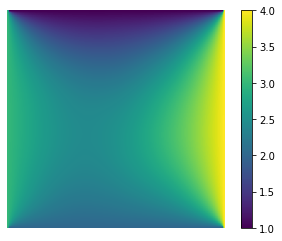

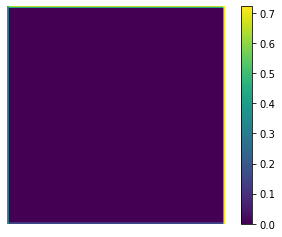

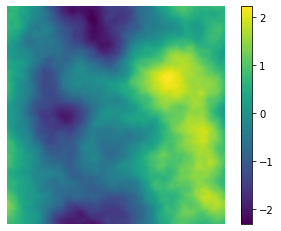

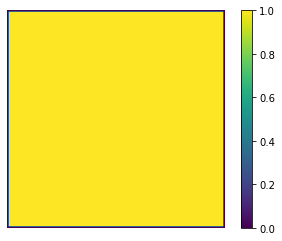

In [4]:
model_name = 'poisson_mg_kernel_129x129'

training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_129x129_nosol.h5')
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 6.657695293426514
1 4.822157859802246
2 3.851752758026123
3 3.240978240966797
4 2.8168365955352783
5 2.502985715866089
6 2.260172128677368
7 2.0660178661346436
8 1.906772255897522
9 1.77349054813385
10 1.6600877046585083
11 1.562270998954773
12 1.476919412612915
13 1.4017070531845093
14 1.3348615169525146
15 1.2750080823898315
16 1.2210625410079956
17 1.1721577644348145
18 1.1275913715362549
19 1.0867878198623657
20 1.0492708683013916
21 1.0146433115005493
22 0.9825700521469116
23 0.9527671933174133
24 0.9249920845031738
25 0.8990360498428345
26 0.8747187852859497
27 0.8518832921981812
28 0.8303926587104797
29 0.8101264834403992
30 0.7909786701202393
31 0.7728552222251892
32 0.7556725144386292
33 0.7393561601638794
34 0.7238394618034363
35 0.7090625166893005
36 0.6949713826179504
37 0.681517481803894
38 0.6686565279960632
39 0.6563485264778137
40 0.6445571184158325
41 0.6332489848136902
42 0.6223937273025513
43 0.6119635105133057
44 0.6019327044487
45 0.5922778844833374
46 0.58297741

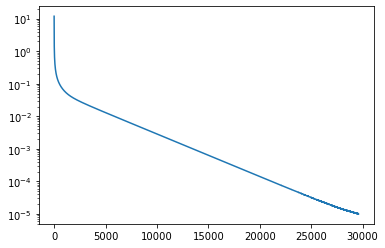

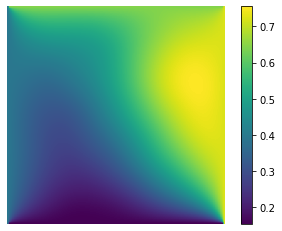

Solution from dataset:


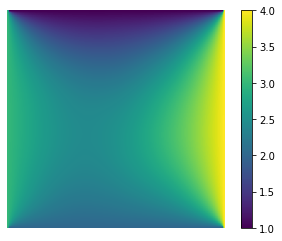

Error (dataset v.s. jacobi):


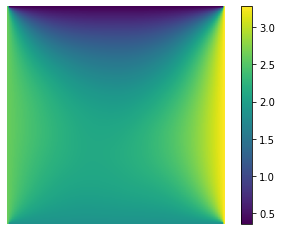

In [5]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.Relax(u_test, f_test, 1)
    residual = f_test-grid.Knet(u_test)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [6]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_tensor_P

tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])

In [7]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [8]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids

        self.mse_loss = nn.MSELoss()
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        #return self.mse_loss(u, u_star)
        resk = self.f - self.grids[0].Knet(uk)
        res0 = self.f - self.grids[0].Knet(self.u0)
        return torch.mean(torch.pow(torch.norm(resk[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/k))

    def forward(self, u0, F, bc_idx, bc_value, k):
        '''Input is initial solution u0, RHS field F, boundary value B, iteration number k'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.grids[0].ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.u0 = self.grids[0].jac.reset_boundary(u0)
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [9]:
def random_sampling(x):
    u = torch.randn_like(x)
    return u

In [10]:
model = MultiGrid(n, linear_tensor_P+0.5*torch.rand((3,3)))
model_linear = MultiGrid(n, linear_tensor_P)

0 11.907175064086914
1 2.643219232559204
2 0.6442304253578186
3 0.15867316722869873
4 0.039365869015455246
5 0.009826695546507835
6 0.002466280246153474
7 0.0006220497889444232
8 0.00015757090295664966
9 4.060370338265784e-05
10 1.193512071040459e-05
11 6.568879143742379e-06
Solution converges after 11 multi-grid iterations 


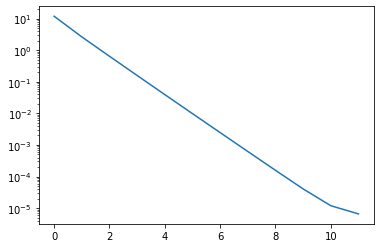

Multigrid solution:


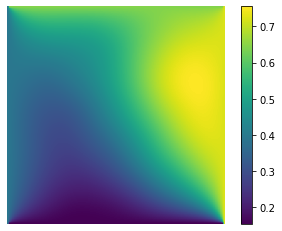

Jacobi solution:


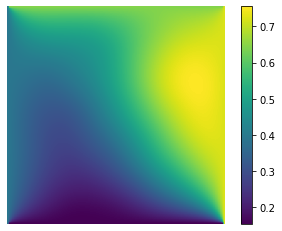

Solution from dataset:


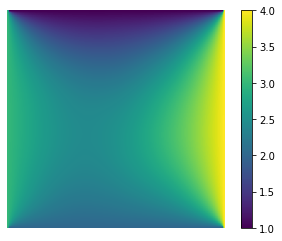

Error (dataset v.s. mg):


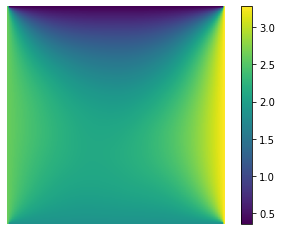

In [11]:
n_multigrid = 0
EPS = 1e-5
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model_linear(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
err_occured = False
residual = model_linear.f-model_linear.grids[0].Knet(model_linear.u0)
res = torch.linalg.matrix_norm(residual[:, :, 1:-1, 1:-1].clone()).item()
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model_linear.iterate(u_mg, model_linear.f)
    residual = model_linear.f-model_linear.grids[0].Knet(u_mg)
    res = torch.linalg.matrix_norm(residual[:, :, 1:-1, 1:-1].clone()).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [12]:
model_dir = 'Model/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.7114, 0.8408, 0.4867],
        [0.6196, 1.2510, 0.8845],
        [0.2802, 0.7620, 0.4924]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.7114, 0.8408, 0.4867],
        [0.6196, 1.2510, 0.8845],
        [0.2802, 0.7620, 0.4924]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [13]:
def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    para_list[1][0,:] = para_list[0][:,0].detach()

In [14]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        u_train, f_train, bc_value_train, bc_index_train = data
        
        optimizer.zero_grad() # zero the gradients for every batch
        k = random.randint(1,10)
        u0 = random_sampling(f_train)

        u_out = model(u0, f_train, bc_index_train, bc_value_train, k)
        loss_i = model.loss(u_out, k)
        
        loss_i.backward()
        para_list = list(model.parameters())
        optimizer.step()
        copy_kernels(para_list) # update the P kernels
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss, para_list[0][0,0].data

In [15]:
num_epoch = 1000
best_vloss = 1_000_000.

loss_train = torch.zeros((num_epoch, 1))
kernel_train = torch.zeros((num_epoch, 3, 3))
for epoch in range(num_epoch):
    model.train(True)
    avg_loss, kernel_i = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train[epoch] = avg_loss
    kernel_train[epoch] = kernel_i.detach().clone()


0 inf
1 inf
2 21.266670543700457
3 17.213300738483667
4 15.12269521644339
5 9.606805455870926
6 8.521161480341107
7 8.101514846086502
8 6.897405461408198
9 6.196831225417554
10 7.310734644532204
11 3.038933815434575
12 3.2666988112032413
13 3.9232091018930078
14 2.8816411155276
15 3.655006012879312
16 2.2710507791489363
17 2.628175823483616
18 2.886283114552498
19 1.918159170076251
20 2.397421922534704
21 2.2104847580194473
22 2.053936445619911
23 1.5326775377616286
24 1.2850364367477596
25 1.2053302619606256
26 1.3332375353202224
27 1.380947289057076
28 1.0161628113128245
29 1.0624742074869573
30 0.9262920282781124
31 0.9304563025943935
32 0.9752717311494052
33 0.95577906165272
34 0.5989044988527894
35 0.9362259563058615
36 0.6667040060274303
37 0.7273112600669265
38 0.7445232202298939
39 0.7872043866664171
40 0.8465271266177297
41 0.5717616248875856
42 0.6171125136315823
43 0.4174484661780298
44 0.477404547855258
45 0.46502919727936387
46 0.5597010771743953
47 0.5405287435278296
48 0

Average q:  tensor(0.1533) , STD:  tensor(0.0092)


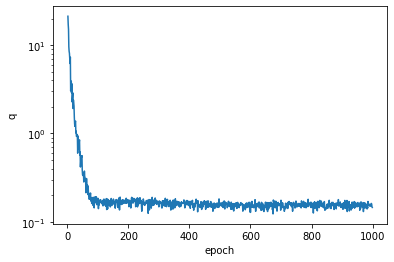

In [16]:
plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

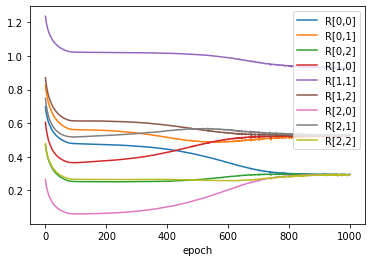

In [17]:
plt.plot(kernel_train[:,0,0], label="R[0,0]")
plt.plot(kernel_train[:,0,1], label="R[0,1]")
plt.plot(kernel_train[:,0,2], label="R[0,2]")
plt.plot(kernel_train[:,1,0], label="R[1,0]")
plt.plot(kernel_train[:,1,1], label="R[1,1]")
plt.plot(kernel_train[:,1,2], label="R[1,2]")
plt.plot(kernel_train[:,2,0], label="R[2,0]")
plt.plot(kernel_train[:,2,1], label="R[2,1]")
plt.plot(kernel_train[:,2,2], label="R[2,2]")
plt.xlabel('epoch')
plt.legend()

In [18]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
torch.save(kernel_train, os.path.join(model_dir,model_name+'-kernels.pt'))

In [19]:
# import the learned model
#model_name = 'poisson_mg_kernel_17x17'
Ps = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
P = torch.mean(Ps[-100:,:,:],dim=0)
print('Learned Restriction/Prolongation kernel:')
print(P)

Learned Restriction/Prolongation kernel:
tensor([[0.2939, 0.5230, 0.2936],
        [0.5249, 0.9308, 0.5267],
        [0.2918, 0.5285, 0.2915]])


In [20]:
#P = linear_tensor_P.clone()

In [21]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

0 358.2124328613281
1 25.300678253173828
2 4.134361743927002
3 0.8331761360168457
4 0.18003873527050018
5 0.040254782885313034
6 0.009196178987622261
7 0.0021325896959751844
8 0.0005005093989893794
9 0.00011888485460076481
10 2.9255754270707257e-05
11 9.55625182541553e-06
Solution converges after 11 multi-grid iterations 


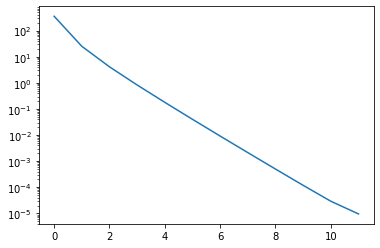

Multigrid solution:


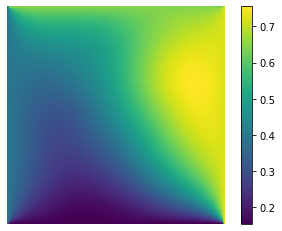

Solution from dataset:


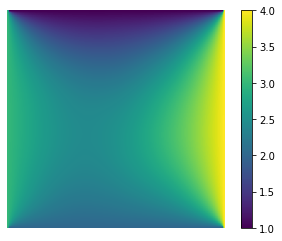

Error (dataset v.s. mg):


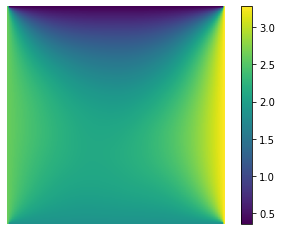

In [22]:
EPS = 1e-5
model = MultiGrid(n, P) # create a new model
n_multigrid = 0
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
u_mg = random_sampling(f_mg)
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = model.f-model.grids[0].Knet(model.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [23]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.32664520411917264
q hat is: 0.20486506819725037


In [24]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.02248024381697178
1.0940024501381493 0.00955891516059637
0.3665052384397483 0.005283798556774855
0.23967741005619564 0.0027675163000822067
0.11260257380535592 0.0014680548338219523
0.0633057070277362 0.0007767811766825616
0.0324209918335233 0.0004113448376301676
0.01745770422084 0.0002177953429054469
0.00916123982353702 0.00011543226719368249
0.004870492522819307 6.125308573246002e-05
0.0025589873113814688 3.2466148695675656e-05
Solution converges after 11 V-cycle iterations with relative error of 0.0025589873113814688


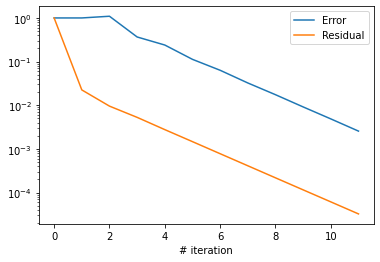

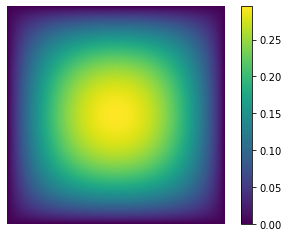

In [25]:
# Multigrid implementation
n = 2**8
model_mg = MultiGrid(n, P) # create a new model
prob_mg = mgTest(model_mg, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [26]:
print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.5300328678538847
